### Gauss-Hermite Integration in Julia

In [2]:
using Plots; pyplot()
include("../julia/aguirregabiria_core.jl")

lambdas = generate_simplex_3dims(10)

55×3 Array{Float64,2}:
 0.0       0.0       1.0        
 0.0       0.111111  0.888889   
 0.0       0.222222  0.777778   
 0.0       0.333333  0.666667   
 0.0       0.444444  0.555556   
 0.0       0.555556  0.444444   
 0.0       0.666667  0.333333   
 0.0       0.777778  0.222222   
 0.0       0.888889  0.111111   
 0.0       1.0       0.0        
 0.111111  0.0       0.888889   
 0.111111  0.111111  0.777778   
 0.111111  0.222222  0.666667   
 ⋮                              
 0.555556  0.333333  0.111111   
 0.555556  0.444444  0.0        
 0.666667  0.0       0.333333   
 0.666667  0.111111  0.222222   
 0.666667  0.222222  0.111111   
 0.666667  0.333333  5.55112e-17
 0.777778  0.0       0.222222   
 0.777778  0.111111  0.111111   
 0.777778  0.222222  0.0        
 0.888889  0.0       0.111111   
 0.888889  0.111111  5.55112e-17
 1.0       0.0       0.0        

In [3]:
rand_n = Int(floor(size(lambdas,1)*10*rand()))+1
#r_lambda_point = lambdas[rand_n,:]
r_lambda_point = [0.44444444, 0.22222222, 0.33333333]

3-element Array{Float64,1}:
 0.444444
 0.222222
 0.333333

In [4]:
function V_0(x) 
    optimal_price = myopic_price(x)
    return period_return(optimal_price, x)
end

V_0(r_lambda_point)

1.6917799949735917

In [5]:
l_price_grid = 10
min_price = 0.5
max_price = 1.5
p_array = linspace(min_price, max_price, l_price_grid)

@time begin
    for i in 1:l_price_grid

        new_lambdas(x) = update_lambdas(x, p_array[i], 2.5, r_lambda_point)
        new_belief(x)  = belief(x, p_array[i], 2.5, r_lambda_point)
        
        #Vguess takes all lambdas except last (because of the simplex)
        integrand(x) = V_0(new_lambdas(x))*new_belief(x)

        logd_min, logd_max = -6, 5 #-6, 2.3
        intgr_value, error_tmp = quadgk(integrand, logd_min, logd_max, maxevals=2000)
        
        println(p_array[i], ", ", intgr_value, " - e=", error_tmp)   

    end
end

0.5, 2.097631943127567 - e=1.2462908311427129e-8
0.6111111111111112, 2.025876185506737 - e=1.1712544574079989e-8
0.7222222222222222, 1.9053169357527093 - e=9.975950343882468e-9
0.8333333333333334, 1.779015516227124 - e=5.82914688304455e-9
0.9444444444444444, 1.7013121937615707 - e=1.3781705148050665e-8
1.0555555555555556, 1.700316094838661 - e=4.6909522704545786e-9
1.1666666666666667, 1.756471419516215 - e=8.891180451159005e-9
1.2777777777777777, 1.8340364655525545 - e=4.096769596183274e-9
1.3888888888888888, 1.9079493335147637 - e=1.2198817287588658e-8
1.5, 1.9692222569380453 - e=2.4191625334116114e-9
  2.608195 seconds (1.12 M allocations: 52.725 MiB, 0.87% gc time)


#### New Belief Check

The `new_belief()` function should behave like a Gaussian mixture:

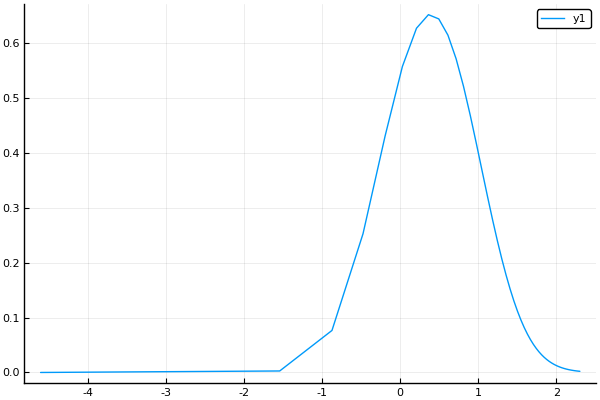

In [6]:
new_belief(x) = belief(x, p_array[8], 2.5, r_lambda_point)

rescaled_demands = log.(linspace(0.01, 10, 50))
new_belief_vals = zeros(50)

for (i, dmd) in enumerate(rescaled_demands)
    new_belief_vals[i] = new_belief(dmd)
end

plot(rescaled_demands, new_belief_vals)

#### Gauss-Hermite integration

In [7]:
using FastGaussQuadrature

In [8]:
function rescale_demand(d, beta_l, price)
    # Rescales demand to use Gauss-Hermite 
    # collocation points.
    mu = alpha + beta_l*log.(price)
    
    return (sqrt(2)*sigma_eps*d + mu)
end

rescale_demand (generic function with 1 method)

In [16]:
function gauss_hermite_integrate(f, price, lambdas, GHx, GHw)
    # Gauss-Hermite integration using pre-computed
    # collocations and weights.
    sum_over_each_lambda = 0.0
    for (l, beta_l) in enumerate(betas_transition)
        for (k, hermite_point) in enumerate(GHx)
            rescaled_remand = rescale_demand(hermite_point, beta_l, price)
            #new_lambdas(x) = update_lambdas(x, price, 2.5, r_lambda_point)
            new_lambdas_val = update_lambdas(rescaled_remand, price, 2.5, r_lambda_point)
            v_value = f(new_lambdas_val)
            sum_over_each_lambda += v_value*GHw[k]*lambdas[l]
        end
    end
    return (1/sqrt(pi) * sum_over_each_lambda)
end

@time nodes, weights = gausshermite(7)

  0.079076 seconds (13.68 k allocations: 742.427 KiB)


([-2.65196, -1.67355, -0.816288, -1.33227e-15, 0.816288, 1.67355, 2.65196], [0.000971781, 0.0545156, 0.425607, 0.810265, 0.425607, 0.0545156, 0.000971781])

#### Time testing & comparison

In [17]:
@time begin
    for p in p_array
        intgr_value = gauss_hermite_integrate(V_0, p, r_lambda_point, nodes, weights)
        println(p, ", ", intgr_value)
    end
end

0.5, 2.108270065230587
0.6111111111111112, 2.022293181873441
0.7222222222222222, 1.9061879343493664
0.8333333333333334, 1.779000129234002
0.9444444444444444, 1.7013121939148848
1.0555555555555556, 1.7003160949136364
1.1666666666666667, 1.75647118766041
1.2777777777777777, 1.8339477279209733
1.3888888888888888, 1.908876715884423
1.5, 1.9698115156591147
  0.066994 seconds (33.50 k allocations: 1.184 MiB)


#### Test with increasing number G.-H. nodes

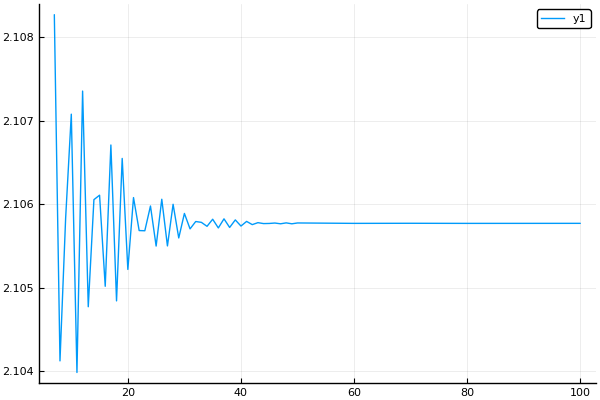

In [35]:
test_values = vcat(collect(7:50), collect(50:10:100))
int_test_values = zeros(length(test_values))
for (i, num_nodes) in enumerate(test_values)
    nodes, weights = gausshermite(num_nodes)
    int_test_values[i] = gauss_hermite_integrate(V_0, p_array[1], r_lambda_point, nodes, weights)
end

plot(test_values, int_test_values)

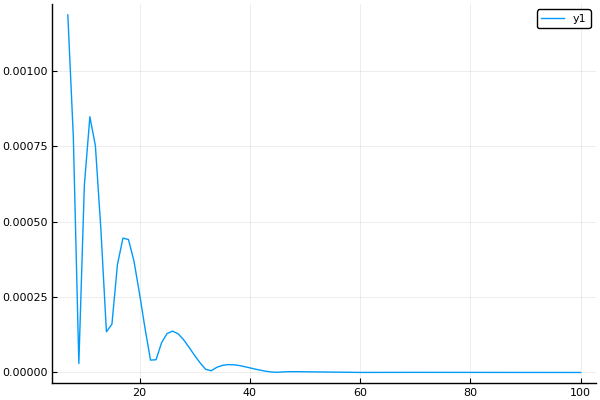

In [36]:
plot(test_values, abs.(int_test_values./int_test_values[end]-1))